In [254]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
# It is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from sklearn.cluster import KMeans


import plotly as py
# Plotly provides online graphing, analytics, and statistics tools
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb
import pickle

In [158]:
all_data = pd.read_csv("customer_segmentation.csv",encoding='cp1252')

In [159]:
all_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Features

In [160]:
all_data['InvoiceDate'] = pd.to_datetime(all_data['InvoiceDate'])
all_data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [161]:
all_data['YearMonth'] = all_data['InvoiceDate'].map(lambda d: d.year*100+d.month)
all_data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012


In [162]:
all_data['Country'].value_counts()
# Selecting UK as it is having the most data

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [163]:
all_uk = all_data[all_data["Country"]=='United Kingdom']#.dropna()
all_uk.shape

(495478, 9)

In [164]:
all_uk.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


# Segmentation Techniques
##### i.e. clustering the customers as:
##### Low value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
##### Mid value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
##### High value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

==>So we need to calculate the RFM(Recency, Frequency and Monetary Value) and apply Unsupervised Learning.

In [165]:
len(all_uk['CustomerID'].unique())

3951

#### Making the dataset

In [166]:
all_user = pd.DataFrame(all_data['CustomerID'].unique(),columns=['CustomerID'])
all_user.head(2)

,CustomerID
0,17850.0
1,13047.0


#### Calculating Recency

In [167]:
uk_recency = all_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_recency.columns = ['CustomerID','lastdate']  # Recency = last purchase date of a user
uk_recency.head(2)

,CustomerID,lastdate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00


In [168]:
overall_lastdate = uk_recency['lastdate'].max()
overall_lastdate

Timestamp('2011-12-09 12:49:00')

In [169]:
uk_recency['Recency'] = (overall_lastdate - uk_recency['lastdate']).dt.days
uk_recency.head(2)

,CustomerID,lastdate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1


In [170]:
all_user = pd.merge(all_user, uk_recency[['CustomerID','Recency']])
all_user.head(2)

,CustomerID,Recency
0,17850.0,301
1,13047.0,31


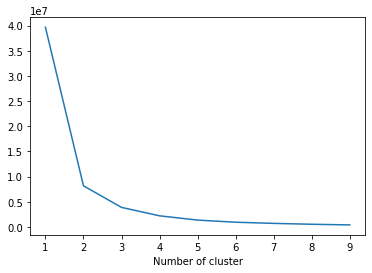

In [171]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = all_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

### As per Elbow method the K found to be 4

Now assigning groups to each IDs using KMean

In [172]:
kmeans = KMeans(n_clusters=4)
all_user['RecencyCluster'] = kmeans.fit_predict(all_user[['Recency']])
all_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,0
2,13748.0,95,2
3,15100.0,329,1
4,15291.0,25,0


In [255]:
pickle.dump(kmeans, open('kmean1.pkl','wb'))

#### Reordering the clusters

In [173]:
means = all_user.groupby('RecencyCluster')['Recency'].mean()
means.head()

RecencyCluster
0     17.488205
1    304.393305
2     77.679245
3    184.625000
Name: Recency, dtype: float64

In [174]:
means = pd.DataFrame(means.sort_values())
means['final'] = np.arange(len(means)-1,-1,-1)
means

,Recency,final
RecencyCluster,,
0,17.488205,3
2,77.679245,2
3,184.625000,1
1,304.393305,0


In [175]:
all_user.head(10)

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,0
2,13748.0,95,2
3,15100.0,329,1
4,15291.0,25,0
5,14688.0,7,0
6,17809.0,15,0
7,15311.0,0,0
8,14527.0,2,0
9,16098.0,87,2


In [176]:
d = dict()
for i in means.index:
    # print(r)
    d[i] = means['final'][i]

d

{0: 3, 2: 2, 3: 1, 1: 0}

In [196]:
all_user['RecencyCluster'] = np.array(d[i] for i in all_user['RecencyCluster'])
all_user.head(10)

,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,3,0,312,1,5288.63,1,1,Low-Value
1,13047.0,31,1,3,196,1,3079.10,0,1,Low-Value
2,13748.0,95,2,2,28,0,948.25,0,-2,Low-Value
3,15100.0,329,3,0,6,0,635.10,0,-1,Low-Value
4,15291.0,25,1,3,109,0,4596.51,1,1,Low-Value
5,14688.0,7,1,3,359,1,5107.38,1,2,Low-Value
6,17809.0,15,1,3,64,0,4627.62,1,1,Low-Value
7,15311.0,0,1,3,2491,2,59419.34,2,4,Mid-Value
8,14527.0,2,1,3,1011,2,7711.38,1,3,Mid-Value
9,16098.0,87,2,2,67,0,2005.63,0,-2,Low-Value


### Calculating Frequency

In [178]:
uk_frequency = all_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
uk_frequency.columns = ['CustomerID','Frequency']
uk_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [179]:
all_user = all_user.merge(uk_frequency)
all_user.head()

,CustomerID,Recency,RecencyCluster,finalcluster,Frequency
0,17850.0,301,1,0,312
1,13047.0,31,0,3,196
2,13748.0,95,2,2,28
3,15100.0,329,1,0,6
4,15291.0,25,0,3,109


#### Frequency clusters

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\2117666810.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\2117666810.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\2117666810.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

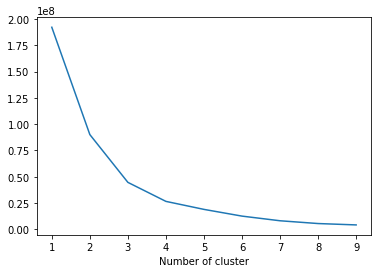

In [180]:
from sklearn.cluster import KMeans

sse={} # error
uk_recency = all_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(uk_recency)
    uk_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

##### So again the K found to be 4

In [181]:
kmeans=KMeans(n_clusters=4)
all_user['FrequencyCluster']=kmeans.fit_predict(all_user[['Frequency']])

#order the frequency cluster
# all_user = order_cluster('FrequencyCluster', 'Frequency', all_user, True )
all_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0


#### Reordering FrequencyCluster

In [182]:
# using the previous codes(Reordering RecencyCluster)

means = all_user.groupby('FrequencyCluster')['Recency'].mean()
means = pd.DataFrame(means.sort_values())
means['final'] = np.arange(len(means)-1,-1,-1)
d = dict()
for i in means.index:
    # print(r)
    d[i] = means['final'][i]

d
all_user['FrequencyCluster'] = np.array(d[i] for i in all_user['FrequencyCluster'])
all_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


### Revenue Cluster

In [183]:
all_data['Revenue'] = all_data['UnitPrice'] * all_data['Quantity']
uk_revenue = all_data.groupby('CustomerID').Revenue.sum().reset_index()
uk_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [184]:
all_user = pd.merge(all_user, uk_revenue, on='CustomerID')
all_user.head()

,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,1,0,312,1,5288.63
1,13047.0,31,0,3,196,1,3079.10
2,13748.0,95,2,2,28,0,948.25
3,15100.0,329,1,0,6,0,635.10
4,15291.0,25,0,3,109,0,4596.51


C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\3995285256.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\3995285256.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\3995285256.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

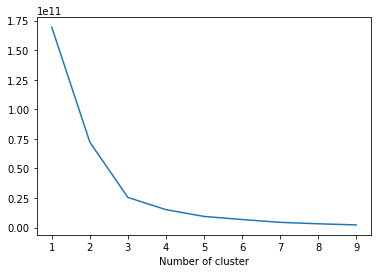

In [185]:
from sklearn.cluster import KMeans

sse={} # error
uk_recency = all_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(uk_recency)
    uk_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Again k = 4 for revenue cluster

In [186]:
kmeans = KMeans(n_clusters=4)
all_user['RevenueCluster'] = kmeans.fit_predict(all_user[['Revenue']])

In [187]:
# using the previous codes(Reordering RevenueCluster)

means = all_user.groupby('RevenueCluster')['Revenue'].mean()
means = pd.DataFrame(means.sort_values())
means['final'] = np.arange(len(means))
d = dict()
for i in means.index:
    # print(r)
    d[i] = means['final'][i]

d
all_user['RevenueCluster'] = np.array(d[i] for i in all_user['RevenueCluster'])
all_user.groupby('RevenueCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,67.382967,88.061395,1.0,16.0,37.0,86.00,981.0
1,234.0,346.918803,314.051084,4.0,158.0,284.5,421.75,2782.0
2,27.0,1165.703704,1878.899326,45.0,194.0,410.0,1068.50,7983.0
3,2.0,392.000000,57.982756,351.0,371.5,392.0,412.50,433.0


## Overall Score based on RFM Clsutering 

In [210]:
all_user['OverallScore'] = all_user['RecencyCluster'] + all_user['FrequencyCluster'] + all_user['RevenueCluster']
# all_user['OverallScore'] = 1/all_user['RecencyCluster'] * all_user['FrequencyCluster'] * all_user['RevenueCluster']
all_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean().sort_values('OverallScore')

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\757208332.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,184.880143,31.992844,472.262721
1,20.133108,65.495946,1056.644440
2,62.308970,100.122924,1494.764885
3,224.753776,111.870091,2458.038097
4,38.382353,749.411765,19224.294706
5,39.250000,1152.625000,91620.851250
6,1.333333,5917.666667,42177.930000


In [211]:
all_user['Segment'] = 'Low-Value'
all_user.loc[all_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
all_user.loc[all_user['OverallScore']>4,'Segment'] = 'High-Value'

In [212]:
all_user

,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,3,0,312,1,5288.63,1,5,High-Value
1,13047.0,31,1,3,196,1,3079.10,0,2,Low-Value
2,13748.0,95,2,2,28,0,948.25,0,2,Low-Value
3,15100.0,329,3,0,6,0,635.10,0,3,Mid-Value
4,15291.0,25,1,3,109,0,4596.51,1,2,Low-Value
...,...,...,...,...,...,...,...,...,...,...
3945,15471.0,1,1,3,77,0,469.48,0,1,Low-Value
3946,13436.0,1,1,3,12,0,196.89,0,1,Low-Value
3947,15520.0,1,1,3,18,0,343.50,0,1,Low-Value
3948,13298.0,0,1,3,2,0,360.00,0,1,Low-Value


In [213]:
all_user.groupby('Segment')['Recency','Frequency','Revenue'].mean()#.sort_values('OverallScore')

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\2333523741.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
Segment,,,
High-Value,28.909091,2452.181818,78136.418182
Low-Value,64.189023,72.576627,1118.570939
Mid-Value,215.649425,143.014368,3277.079368


In [218]:
all_data['InvoiceDate'].describe()

C:\Users\Guddu\AppData\Local\Temp\ipykernel_19424\314425542.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [220]:
all_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,201112,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,201112,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,16.60


In [228]:
tx_3m = all_data[(all_data.InvoiceDate < pd.Timestamp(date(2011,6,1))) & (all_data.InvoiceDate >= pd.Timestamp(date(2011,3,1)))].reset_index(drop=True) #3 months time
tx_6m = all_data[(all_data.InvoiceDate >= pd.Timestamp(date(2011,6,1))) & (all_data.InvoiceDate < pd.Timestamp(date(2011,12,1)))].reset_index(drop=True) # 6 months time

In [232]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']
tx_user_6m.head()


,CustomerID,m6_Revenue
0,12347.0,2261.75
1,12348.0,310.00
2,12349.0,1757.55
3,12352.0,944.23
4,12356.0,58.35


In [233]:
plot_data = [
    go.Histogram(
        x=tx_user_6m['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [235]:
all_user.head()


,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,3,0,312,1,5288.63,1,5,High-Value
1,13047.0,31,1,3,196,1,3079.10,0,2,Low-Value
2,13748.0,95,2,2,28,0,948.25,0,2,Low-Value
3,15100.0,329,3,0,6,0,635.10,0,3,Mid-Value
4,15291.0,25,1,3,109,0,4596.51,1,2,Low-Value


In [236]:
all_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [238]:
tx_merge = pd.merge(all_user, tx_user_6m, on='CustomerID', how='left') #Only people who are in the timeline of tx_user_6m

In [239]:
tx_graph = tx_merge.query("m6_Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [241]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]
tx_merge.head()


,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
1,13047.0,31,1,3,196,1,3079.10,0,2,Low-Value,1425.42
2,13748.0,95,2,2,28,0,948.25,0,2,Low-Value,367.40
4,15291.0,25,1,3,109,0,4596.51,1,2,Low-Value,1980.01
5,14688.0,7,1,3,359,1,5107.38,1,3,Mid-Value,1702.06
6,17809.0,15,1,3,64,0,4627.62,1,2,Low-Value,1976.92


In [242]:
kmeans = KMeans(n_clusters=3)
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m6_Revenue']])

tx_merge.head()

,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
1,13047.0,31,1,3,196,1,3079.10,0,2,Low-Value,1425.42,1
2,13748.0,95,2,2,28,0,948.25,0,2,Low-Value,367.40,0
4,15291.0,25,1,3,109,0,4596.51,1,2,Low-Value,1980.01,1
5,14688.0,7,1,3,359,1,5107.38,1,3,Mid-Value,1702.06,1
6,17809.0,15,1,3,64,0,4627.62,1,2,Low-Value,1976.92,1


In [244]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

NameError: name 'tx_user' is not defined

In [245]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2203.0,383.825144,271.266472,-4287.63,186.5150,339.00,557.2850,966.00
1,722.0,1550.477050,452.330989,969.79,1159.7400,1461.97,1843.8500,2687.56
2,178.0,3866.155000,943.146410,2740.43,3093.4575,3573.26,4360.8925,6220.51


In [246]:
tx_cluster.head()


,CustomerID,Recency,RecencyCluster,finalcluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,13047.0,31,1,3,196,1,3079.10,0,2,Low-Value,1425.42,1
1,15291.0,25,1,3,109,0,4596.51,1,2,Low-Value,1980.01,1
2,14688.0,7,1,3,359,1,5107.38,1,3,Mid-Value,1702.06,1
3,17809.0,15,1,3,64,0,4627.62,1,2,Low-Value,1976.92,1
4,16098.0,87,2,2,67,0,2005.63,0,2,Low-Value,995.33,1


In [247]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster) #There is only one categorical variable segment
tx_class.head()

C:\Users\Guddu\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



,CustomerID,Recency,Frequency,Revenue,m6_Revenue,LTVCluster,RecencyCluster_0,RecencyCluster_1,RecencyCluster_2,finalcluster_1,...,FrequencyCluster_2,RevenueCluster_0,RevenueCluster_1,OverallScore_0,OverallScore_1,OverallScore_2,OverallScore_3,OverallScore_4,Segment_Low-Value,Segment_Mid-Value
0,13047.0,31,196,3079.10,1425.42,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,15291.0,25,109,4596.51,1980.01,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
2,14688.0,7,359,5107.38,1702.06,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
3,17809.0,15,64,4627.62,1976.92,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
4,16098.0,87,67,2005.63,995.33,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [248]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.895030
Revenue               0.805439
RevenueCluster_1      0.611899
Frequency             0.545063
Segment_Mid-Value     0.492985
FrequencyCluster_1    0.468884
OverallScore_3        0.451581
RecencyCluster_1      0.285627
finalcluster_3        0.285627
OverallScore_4        0.194244
FrequencyCluster_2    0.172808
OverallScore_2        0.005942
CustomerID           -0.034624
OverallScore_1       -0.119855
finalcluster_2       -0.180624
RecencyCluster_2     -0.180624
finalcluster_1       -0.185792
RecencyCluster_0     -0.185792
OverallScore_0       -0.186401
Recency              -0.320168
Segment_Low-Value    -0.492985
FrequencyCluster_0   -0.497645
RevenueCluster_0     -0.611899
Name: LTVCluster, dtype: float64

In [249]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [251]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

C:\Users\Guddu\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.84


C:\Users\Guddu\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\Guddu\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [252]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.90      0.91       112
           1       0.67      0.65      0.66        37
           2       0.60      0.86      0.71         7

    accuracy                           0.84       156
   macro avg       0.73      0.80      0.76       156
weighted avg       0.84      0.84      0.84       156

